# **Exploratory Data Analysis For Fair Use Cases Data**

**BA820 - Project Milestone 2**

**Team:** B1 Team 13

**Team Members:** Rita Feng

# Introduction

This project uses a public dataset of U.S. fair use decisions from the U.S. Copyright Office Fair Use Index. Each record summarizes a case and includes structured attributes such as the court, jurisdiction, year, and content categories, along with text fields describing the facts, legal issue, and holding. The dataset also contains an outcome indicator showing whether fair use was found.

This notebook focuses on the fact-based precedent finder domain identified in the previous stage of the project. The goal is to demonstrate how the data can be leveraged to improve case filtering and evaluation by identifying meaningful patterns that connect disputes with similar factual structures. Rather than simply replicating prior exploratory work, this notebook emphasizes how structured and textual features can support practical decision-making in legal triage.


# Setting Up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Data Importing, Inspection and Preparation

## Data Importing

In [2]:
fair_use_cases = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-08-29/fair_use_cases.csv')
fair_use_findings = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-08-29/fair_use_findings.csv')

## Data Inspection

### Fair Use Cases Table

The `fair_use_cases` table provides one row per case with structured metadata such as year, court, jurisdiction, content categories, and a binary indicator for whether fair use was found. Inspection focuses on confirming completeness, consistency of categorical fields, and suitability for comparing outcomes across courts, categories, and time.

| variable       | class     | description                                                                                                   |
| -------------- | --------- | ------------------------------------------------------------------------------------------------------------- |
| case           | character | The name and number of the case.                                                                              |
| year           | integer   | The year in which the case was decided.                                                                       |
| court          | character | The court in which the ruling was made.                                                                       |
| jurisdiction   | character | The jurisdiction of that court.                                                                               |
| categories     | character | A comma- or semicolon-separated list of categories to which the case belongs. These have not been normalized. |
| outcome        | character | A string describing the outcome of the case.                                                                  |
| fair_use_found | logical   | Whether fair use was found by the court. FALSE might sometimes indicate a more complicated finding.           |

In [3]:
print("Dataset Info:")
print(fair_use_cases.info())

print("\nFirst 5 rows:")
print(fair_use_cases.head())

print("\nMissing Values:")
print(fair_use_cases.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   case            251 non-null    object
 1   year            251 non-null    int64 
 2   court           251 non-null    object
 3   jurisdiction    251 non-null    object
 4   categories      251 non-null    object
 5   outcome         251 non-null    object
 6   fair_use_found  251 non-null    bool  
dtypes: bool(1), int64(1), object(5)
memory usage: 12.1+ KB
None

First 5 rows:
                                                case  year        court  \
0  De Fontbrune v. Wofsy, 39 F.4th 1214 (9th Cir....  2022  9th Circuit   
1  Sedlik v. Von Drachenberg, No. CV 21-1102 (C.D...  2022    C.D. Cal.   
2  Sketchworks Indus. Strength Comedy, Inc. v. Ja...  2022     S.D.N.Y.   
3  Am. Soc'y for Testing & Materials v. Public.Re...  2022       D.D.C.   
4  Yang v. Mic Network Inc., No

### Fair Use Findings Table

The `fair_use_findings` table contains complementary case-level text, including summaries of key facts, legal issues, holdings, and descriptive tags. Inspection centers on text completeness and variability, as these fields support later analysis of language patterns, similarity, and thematic structure across cases.

| variable    | class     | description                                                                            |
| ----------- | --------- | -------------------------------------------------------------------------------------- |
| title       | character | The title of the case.                                                                 |
| case_number | character | The case number or numbers of the case.                                                |
| year        | character | The year in which the finding was made (or findings were made).                        |
| court       | character | The court or courts involved.                                                          |
| key_facts   | character | The key facts of the case.                                                             |
| issue       | character | A brief description of the fair use issue.                                             |
| holding     | character | The decision of the court in paragraph form.                                           |
| tags        | character | Comma- or semicolon-separated tags for this case.                                      |
| outcome     | character | A brief description of the outcome of the case. These fields have not been normalized. |

In [4]:
print("Dataset Info:")
print(fair_use_findings.info())

print("\nFirst 5 rows:")
print(fair_use_findings.head())

print("\nMissing Values:")
print(fair_use_findings.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        251 non-null    object
 1   case_number  251 non-null    object
 2   year         251 non-null    object
 3   court        251 non-null    object
 4   key_facts    251 non-null    object
 5   issue        251 non-null    object
 6   holding      251 non-null    object
 7   tags         251 non-null    object
 8   outcome      251 non-null    object
dtypes: object(9)
memory usage: 17.8+ KB
None

First 5 rows:
                                               title  \
0                              De Fontbrune v. Wofsy   
1                          Sedlik v. Von Drachenberg   
2  Sketchworks Indus. Strength Comedy, Inc. v. Ja...   
3  Am. Soc'y for Testing & Materials v. Public.Re...   
4                           Yang v. Mic Network Inc.   

                                 

## Preparing Data

The two files describe the same cases, so the first merge attempt is to recreate the `case` string in `fair_use_findings` by combining `title` and `case_number`, then merge on `case`. After merging, the match rate is checked to see how many rows successfully pulled in text fields.

In [6]:
import pandas as pd
import difflib

names_in_cases = fair_use_cases["case"].astype(str).unique()
names_in_findings = fair_use_findings["title"].astype(str).unique()

mapping_dict = {}

for name in names_in_cases:
    matches = difflib.get_close_matches(name, names_in_findings, n=1, cutoff=0.4)

    if matches:
        mapping_dict[name] = matches[0]

for k, v in list(mapping_dict.items())[:5]:
    print(f"  '{k}'  ==>  '{v}'")

fair_use_cases["mapped_title"] = fair_use_cases["case"].map(mapping_dict)

fair_use_merged = fair_use_cases.merge(
    fair_use_findings,
    left_on="mapped_title",
    right_on="title",
    how="inner"
)


  'De Fontbrune v. Wofsy, 39 F.4th 1214 (9th Cir. 2022)'  ==>  'De Fontbrune v. Wofsy'
  'Sedlik v. Von Drachenberg, No. CV 21-1102 (C.D. Cal. May 31, 2022)'  ==>  'Sedlik v. Von Drachenberg'
  'Sketchworks Indus. Strength Comedy, Inc. v. Jacobs, No. 19-CV-7470-LTS-VF (S.D.N.Y. May 12, 2022)'  ==>  'Sketchworks Indus. Strength Comedy, Inc. v. Jacobs'
  'Am. Soc'y for Testing & Materials v. Public.Resource.Org, Inc., No. 13-cv-1215 (D.D.C. Mar. 31, 2022)'  ==>  'Am. Soc'y for Testing & Materials v. Public.Resource.Org, Inc.'
  'Yang v. Mic Network Inc., Nos. 20-4097-cv, 20-4201-cv (2d Cir. Mar. 29, 2022)'  ==>  'Yang v. Mic Network Inc.'


because of original code, we tried to merge the two database by add case_number it lower the chance to be match. this times we didnt add teh case_number and use the difflib it will be more fuzzy and if the match is over the 0.4 limit then it will count fo the same case. it enhanced the match chance.

In [7]:
fair_use_merged.head()

,case,year_x,court_x,jurisdiction,categories,outcome_x,fair_use_found,mapped_title,title,case_number,year_y,court_y,key_facts,issue,holding,tags,outcome_y
0,"De Fontbrune v. Wofsy, 39 F.4th 1214 (9th Cir....",2022,9th Circuit,9th Circuit,Education/Scholarship/Research; Photograph,Fair use not found,False,De Fontbrune v. Wofsy,De Fontbrune v. Wofsy,39 F.4th 1214 (9th Cir. 2022),2022,United States Court of Appeals for the Ninth C...,Plaintiffs own the rights to a catalogue compr...,Whether reproduction of photographs documentin...,"The panel held that the first factor, the purp...",Education/Scholarship/Research; Photograph,Fair use not found
1,"Sedlik v. Von Drachenberg, No. CV 21-1102 (C.D...",2022,C.D. Cal.,9th Circuit,Painting/Drawing/Graphic; Photograph,Preliminary finding; Fair use not found,False,Sedlik v. Von Drachenberg,Sedlik v. Von Drachenberg,"No. CV 21-1102, 2022 WL 2784818 (C.D. Cal. May...",2022,United States District Court for the Southern ...,Plaintiff Jeffrey Sedlik is a photographer who...,Whether use of a photograph as the reference i...,"Considering the first fair use factor, the pur...",Painting/Drawing/Graphic; Photograph,Preliminary finding; Fair use not found
2,"Sketchworks Indus. Strength Comedy, Inc. v. Ja...",2022,S.D.N.Y.,2nd Circuit,Film/Audiovisual; Music; Parody/Satire; Review...,Fair use found,True,"Sketchworks Indus. Strength Comedy, Inc. v. Ja...","Sketchworks Indus. Strength Comedy, Inc. v. Ja...","No. 19-CV-7470-LTS-VF, 2022 U.S. Dist. LEXIS 8...",2022,United States District Court for the Southern ...,Plaintiff Sketchworks Industrial Strength Come...,"Whether the use of protected elements, includi...","The court found that the first factor, the pur...",Film/Audiovisual; Music; Parody/Satire; Review...,Fair use found
3,Am. Soc'y for Testing & Materials v. Public.Re...,2022,D.D.C.,District of Columbia Circuit,Education/Scholarship/Research; Textual Work; ...,Mixed Result,False,Am. Soc'y for Testing & Materials v. Public.Re...,Am. Soc'y for Testing & Materials v. Public.Re...,"No. 13-cv-1215 (TSC), 2022 U.S. Dist. LEXIS 60...",2022,United States District Court for the District ...,"Defendant Public.Resource.Org, Inc., a non-pro...",Whether it is fair use to make available onlin...,"As directed by the court of appeals, the distr...",Education/Scholarship/Research; Textual Work; ...,Mixed Result
4,"Yang v. Mic Network Inc., Nos. 20-4097-cv, 20-...",2022,2d Circuit,2nd Circuit,News reporting; Photography,Fair use found,True,Yang v. Mic Network Inc.,Yang v. Mic Network Inc.,"Nos. 20-4097-cv(L), 20-4201-cv (XAP), 2022 U.S...",2022,United States Court of Appeals for the Second ...,Plaintiff Stephen Yang (“Yang”) licensed a pho...,"Whether using a screenshot from an article, in...","On appeal, the court decided that the first fa...",News Reporting; Photography,Fair use found


for my domain i will drop some columns because it is not the useful information for my case, to avoid noise i choose to drop it.

In [8]:

cols_to_drop = ["jurisdiction", "case_number", "join_key","mapped_title", "title" ]

fair_use_final = fair_use_merged.drop(
columns=[c for c in cols_to_drop if c in fair_use_merged.columns])
cols_to_drop_duplicates = [c for c in fair_use_final.columns if c.endswith('_y')]
fair_use_final = fair_use_final.drop(columns=cols_to_drop_duplicates)
fair_use_final.columns = [c.replace('_x', '') for c in fair_use_final.columns]

print(fair_use_final.columns.tolist())
print(fair_use_final.head(2))

['case', 'year', 'court', 'categories', 'outcome', 'fair_use_found', 'key_facts', 'issue', 'holding', 'tags']
                                                case  year        court  \
0  De Fontbrune v. Wofsy, 39 F.4th 1214 (9th Cir....  2022  9th Circuit   
1  Sedlik v. Von Drachenberg, No. CV 21-1102 (C.D...  2022    C.D. Cal.   

                                   categories  \
0  Education/Scholarship/Research; Photograph   
1        Painting/Drawing/Graphic; Photograph   

                                   outcome  fair_use_found  \
0                       Fair use not found           False   
1  Preliminary finding; Fair use not found           False   

                                           key_facts  \
0  Plaintiffs own the rights to a catalogue compr...   
1  Plaintiff Jeffrey Sedlik is a photographer who...   

                                               issue  \
0  Whether reproduction of photographs documentin...   
1  Whether use of a photograph as the reference 

# Exploratory Data Analysis (EDA)

This EDA looks at the two tables as they are: `fair_use_cases` contains structured metadata (year, court, jurisdiction, categories, outcome, fair_use_found) and `fair_use_findings` adds narrative text (key_facts, issue, holding) plus tags. Because the identifiers do not merge reliably with simple string matching, the exploration is done separately, using tables plus plots to summarize the main patterns.

## Part 1: risk by category

because of the finder, we want to figure out what type ofthe the category has more risk, in here we will use the difference category to and different precentage winning to have a better understanding which category have higher risk

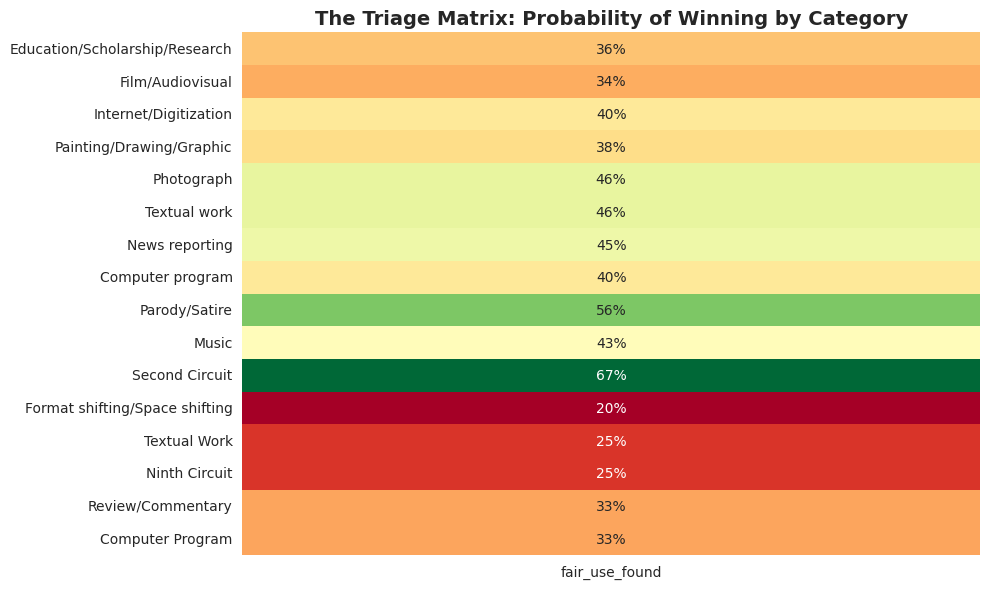

In [9]:
if 'categories' in fair_use_final.columns:
    fair_use_final['primary_category'] = fair_use_final['categories'].astype(str).apply(lambda x: x.split(';')[0].strip())


    category_risk = fair_use_final.groupby('primary_category')['fair_use_found'].mean().sort_values(ascending=False)


    counts = fair_use_final['primary_category'].value_counts()
    valid_cats = counts[counts >= 3].index
    category_risk = category_risk[valid_cats]


    plt.figure(figsize=(10, 6))
    sns.heatmap(pd.DataFrame(category_risk), annot=True, fmt=".0%", cmap="RdYlGn", cbar=False)

    plt.title('The Triage Matrix: Probability of Winning by Category', fontsize=14, fontweight='bold')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

## Part 2: Fact Complexity

i use the historgram to show how many word inside the case. because for the case if the words less than 20, it lack the context so i set a standard of the 20, if the case leess than 20 i will cut it off

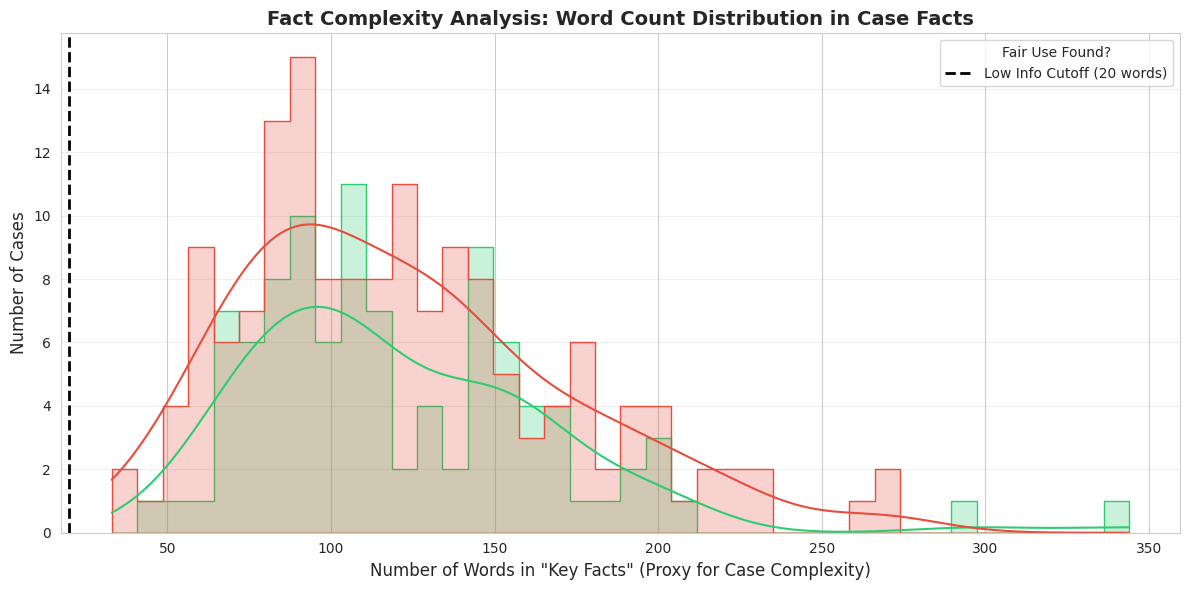

the longest: 344 words
the shortest: 33 words
less than 20 words: 0


In [12]:
fair_use_final['fact_length'] = fair_use_final['key_facts'].fillna('').apply(lambda x: len(str(x).split()))


plt.figure(figsize=(12, 6))


sns.histplot(
    data=fair_use_final,
    x='fact_length',
    hue='fair_use_found',
    element="step",
    bins=40,
    kde=True,
    palette={True: "#2ecc71", False: "#e74c3c"}
)


plt.axvline(x=20, color='black', linestyle='--', linewidth=2, label='Low Info Cutoff (20 words)')


plt.title('Fact Complexity Analysis: Word Count Distribution in Case Facts', fontsize=14, fontweight='bold')
plt.xlabel('Number of Words in "Key Facts" (Proxy for Case Complexity)', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)
plt.legend(title='Fair Use Found?')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


print(f"the longest: {fair_use_final['fact_length'].max()} words")
print(f"the shortest: {fair_use_final['fact_length'].min()} words")
print(f"less than 20 words: {len(fair_use_final[fair_use_final['fact_length'] < 20])}")

according to the graph, we can see that the green part(sucess) and the red part have lots of overlap, but green part is more flat, and it tend to the right more, which means the successful case the court need more eveidence to be pursued

## Part 3: Temporal Trends

This section looks at Line Chart: Legal Volume Over Time.

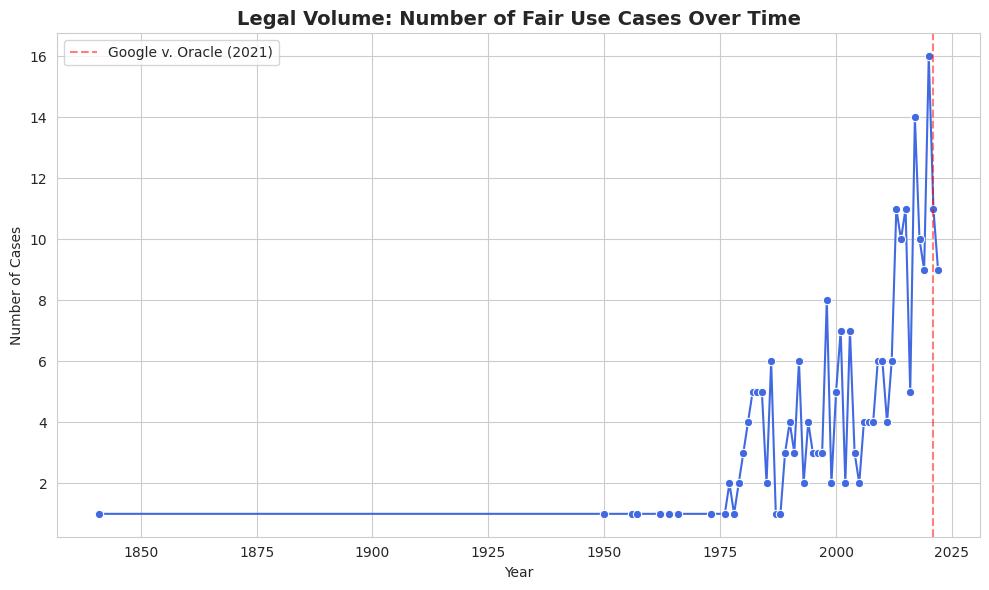

In [13]:
if 'year' in fair_use_final.columns:
    plt.figure(figsize=(10, 6))


    cases_per_year = fair_use_final.groupby('year')['case'].count()

    sns.lineplot(x=cases_per_year.index, y=cases_per_year.values, marker='o', color='royalblue')

    plt.title('Legal Volume: Number of Fair Use Cases Over Time', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Cases')
    plt.xlabel('Year')


    plt.axvline(x=2021, color='red', linestyle='--', alpha=0.5, label='Google v. Oracle (2021)')
    plt.legend()

    plt.tight_layout()
    plt.show()

as the time increase, the numver of the case incrase lot too, maybe because of the more sucessful technology so people can use it easier.

## Part 4: Court Bias

Finally, inspect the court bias, so get an insight about which court have higeher fair case

/tmp/ipython-input-2345435659.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_courts.values, y=top_courts.index, palette='viridis')


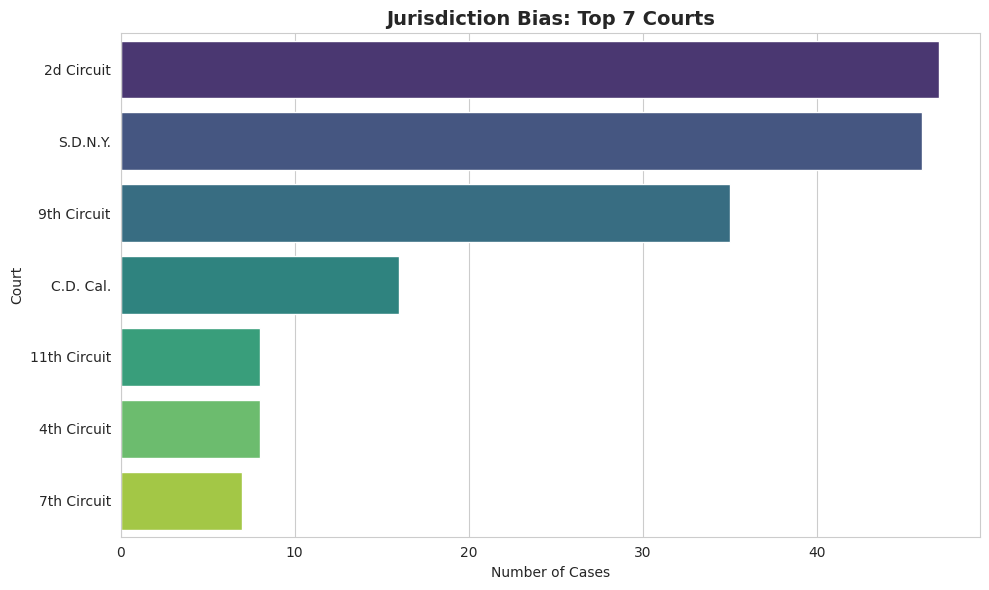

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

top_courts = fair_use_final['court'].value_counts().head(7)


sns.barplot(x=top_courts.values, y=top_courts.index, palette='viridis')


plt.title('Jurisdiction Bias: Top 7 Courts', fontsize=14, fontweight='bold')
plt.xlabel('Number of Cases')
plt.ylabel('Court')


plt.tight_layout()
plt.show()


according to the graph we can see the 2d circuit have the highest fair case

The most frequent terms are strongly legal and decision-focused (for example, use, court, fair, factor, market, defendant), which confirms the holdings are written in consistent judicial language. This also suggests that later NLP steps should filter generic legal boilerplate (and possibly combine singular/plural forms like defendant/defendants and work/works) to better surface content-specific themes.

** Model

# Summary

Next Steps
